## МЕТОД ГЛАВНЫХ КОМПОНЕНТ

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [35]:
train, validation, test = load_mnist()
X_train, y_train = train
X_test, y_test = test

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


In [36]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(55000, 28, 28, 1) (55000,)
(10000, 28, 28, 1) (10000,)


# I. Визуализация датасета

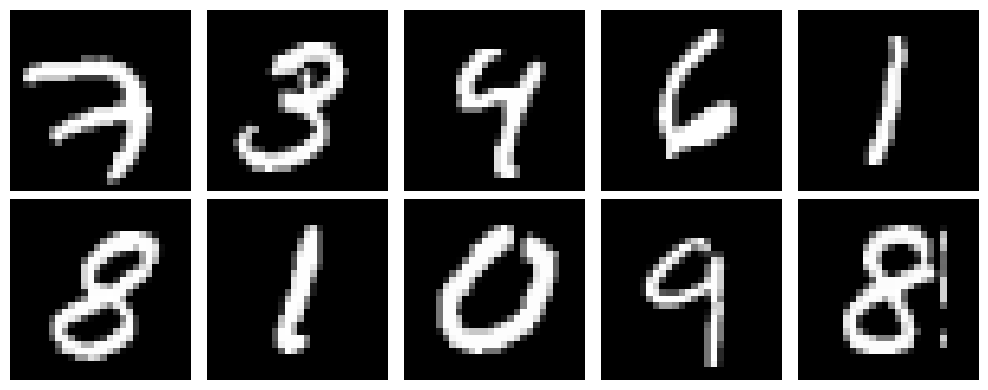

In [37]:
fig, axes = plt.subplots(2, 5, figsize = (10, 4))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(X_train[i].reshape(28, 28), cmap = 'gray')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# II. Алгоритм PCA

In [38]:
class my_PCA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean = None
        self.eigenvectors = None
        self.eigenvalues = None

    def fit(self, X):
        self.mean = np.mean(X, axis = 0)
        centered_X = X - self.mean
        cov_matrix = np.cov(centered_X, rowvar = False)
        self.eigenvalues, self.eigenvectors = np.linalg.eig(cov_matrix)

        idx = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[idx]
        self.eigenvectors = self.eigenvectors[:, idx]

    def transform(self, X):
        centered_X = X - self.mean
        if self.n_components is not None:
            reduced_eigenvectors = self.eigenvectors[:, :self.n_components]
            return np.dot(centered_X, reduced_eigenvectors)
        else:
            return np.dot(centered_X, self.eigenvectors)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [39]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

pca = my_PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train)

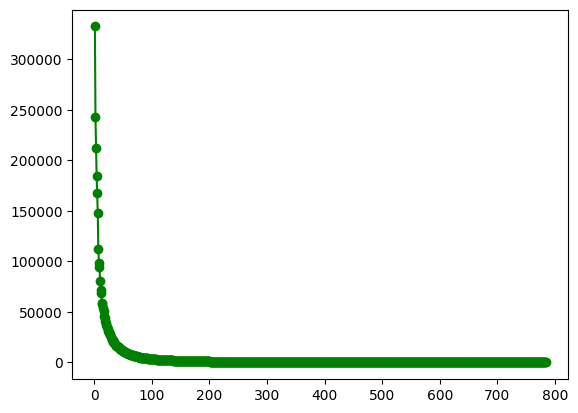

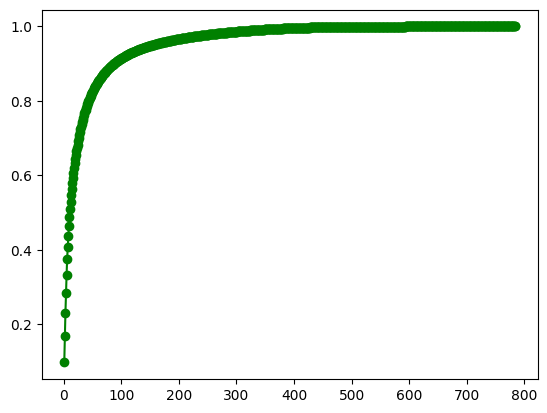

In [42]:
plt.plot(np.arange(1, 785), pca.eigenvalues, marker = 'o', linestyle = '-', color = 'g')
plt.show()

cumulative_sum = np.cumsum(pca.eigenvalues) / np.sum(pca.eigenvalues)
plt.plot(np.arange(1, 785), cumulative_sum, marker = 'o', linestyle = '-', color = 'g')
plt.show()

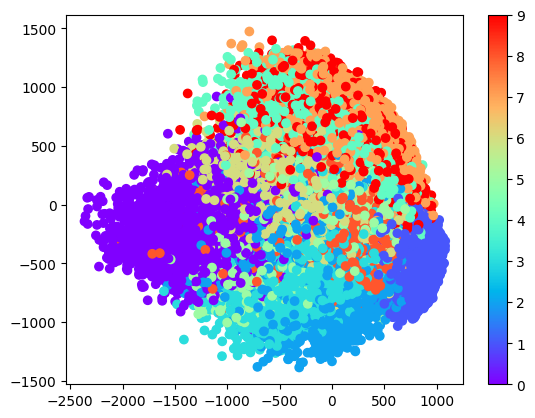

In [43]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c = y_train, cmap = 'rainbow')
plt.colorbar()
plt.show()

# III. Алгоритм kNN

In [44]:
class my_kNN():
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        distances = np.sqrt(np.sum((X[:, np.newaxis] - self.X_train)**2, axis = 2))
        nearest_indices = np.argsort(distances, axis = 1)[:, :self.n_neighbors]
        nearest_labels = self.y_train[nearest_indices]
        predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis = 1, arr = nearest_labels)
        return predictions

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X_train_pca, y_train, test_size = 0.05, random_state = 42)

In [24]:
knn = my_kNN(n_neighbors = 10)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("Точность:", accuracy)

Точность: 0.4283636363636364


In [25]:
pca = my_PCA(n_components = 1)
X_train_pca = pca.fit_transform(X_train)

knn = my_kNN(n_neighbors = 5)
knn.fit(X_train_pca, y_train)

y_pred = knn.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("Точность:", accuracy)

Точность: 0.16472727272727272


In [46]:
best_accuracy = 0
best_params = {}

for n_components in range(16, 65, 16):
    for n_neighbors in range(5, 31, 5):
        pca = my_PCA(n_components = n_components)
        X_train_pca = pca.fit_transform(X_train)

        knn = my_kNN(n_neighbors=n_neighbors)
        knn.fit(X_train_pca, y_train)
        
        X_val_pca = pca.transform(X_val)
        y_pred = knn.predict(X_val_pca)

        accuracy = accuracy_score(y_val, y_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params['n_components'] = n_components
            best_params['n_neighbors'] = n_neighbors

print("Наилучшая точность:", best_accuracy)
print("Наилучшие параметры:", best_params)

Наилучшая точность: 0.4556363636363636
Наилучшие параметры: {'n_components': 16, 'n_neighbors': 30}


# Вывод

При использовании алгоритма k-ближайших соседей (kNN) на данных, преобразованных с помощью метода главных компонент (PCA), достигнута точность 0.45381818181818184 при оптимальных параметрах: 8 компонент и 25 соседей.
PCA позволяет уменьшить размерность данных, сохраняя основные характеристики. Комбинация PCA и kNN является мощным инструментом для классификации данных: учитывает близость к соседним объектам и наиболее информативные компоненты. Однако стоит отметить, что выбор оптимальных параметров для PCA (количество компонент) и kNN (количество соседей) может потребовать исследования и настройки. В данном случае использовалась собственная реализация PCA и kNN.
В целом, применение PCA и kNN вместе может быть полезным инструментом для анализа и классификации данных, и эти методы могут быть применены в различных областях(распознавание образов, биометрия и т.д)